# Neural Network Chess AI

Simple Neural Network Chess AI using tensorflow, made for the Machine Learning class at Insper, by Arthur Olga and Lucas Vaz



In [1]:
# Python Chess
!pip install chess~=1.5.0

     |████████████████████████████████| 153kB 8.2MB/s 


In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Assuming you have stockfish on Google Drive
!chmod +x '/content/drive/My Drive/ChessAI/stockfish-10-linux/Linux/stockfish_10_x64'

chmod: cannot access '/content/drive/My Drive/ChessAI/stockfish-10-linux/Linux/stockfish_10_x64': Not a directory


In [4]:
import chess
import chess.engine
import chess.svg
import random
import numpy

# Tensorflow
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.losses as losses

# Jupyter Displays
from IPython.display import display
import ipywidgets as widgets

## Python Chess

Showing a simple board and how to move pieces with commands. This package will be used for playing chess using Python

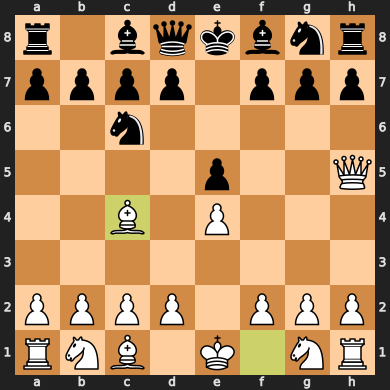

In [5]:
# Create board
board = chess.Board()
# Move pieces
board.push_san("e4") 
board.push_san("e5")
board.push_san("Qh5")
board.push_san("Nc6")
board.push_san("Bc4")
# Show Board
board

In [6]:
# Board3D based on https://www.nigamavykari.me/training-an-ai-to-play-chess/
squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}


# example: e3 -> (3, 4)
def square_to_index(square):
  letter = chess.square_name(square)
  return 8 - int(letter[1]), squares_index[letter[0]]


def split_dims(board):
  # this is the 3d matrix
  # 7 matrix for each player: pawns, knights, bishops, rooks, queens, king and valid moves
  # obs: 13th and 14th are the valid moves matrixes
  board3d = numpy.zeros((14, 8, 8), dtype=numpy.int8)

  # here we add the pieces's view on the matrix
  for piece in chess.PIECE_TYPES:
    for square in board.pieces(piece, chess.WHITE):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece + 5][7 - idx[0]][idx[1]] = 1

  # legal moves
  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[12][i][j] = 1
  board.turn = chess.BLACK
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[13][i][j] = 1
  board.turn = aux

  return board3d

In [7]:
split_dims(board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [8]:
def get_model(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = board3d
  x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same',  activation='relu', data_format='channels_first')(x)
  for _ in range(conv_depth):
    past_x = x
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same',  activation='relu', data_format='channels_first')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x,past_x])
    x = layers.Activation('relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, 'relu')(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

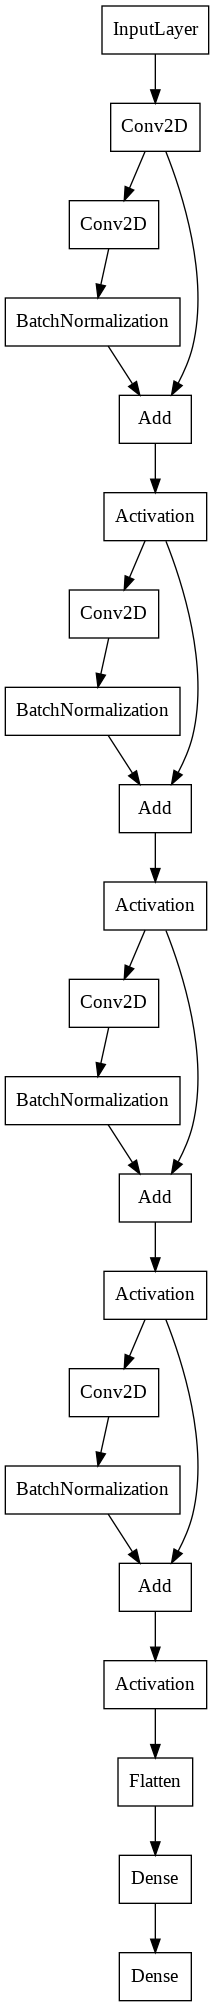

In [9]:
model = get_model(32,4)
utils.plot_model(model,show_layer_names=False)

In [10]:
# Dataset created based on https://www.nigamavykari.me/training-an-ai-to-play-chess/
import tensorflow.keras.callbacks as callbacks

def get_dataset():
	container = numpy.load('/content/drive/My Drive/Chess_AI/dataset.npz')
	b, v = container['b'], container['v']
	v = numpy.asarray(v / abs(v).max() / 2 + 0.5, dtype=numpy.float32) # normalization (0 - 1)
	return b, v


x_train, y_train= get_dataset()
print(x_train.shape)
print(y_train.shape)

(1500000, 14, 8, 8)
(1500000,)


In [11]:
model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')

model.summary()
model.fit(x_train, y_train,
          batch_size=2048,
          epochs=1000,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4)])

model.save('model-ResConv2d.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 8, 8)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 8, 8)     4064        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 8, 8)     9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 8, 8)     32          conv2d_1[0][0]                   
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [13]:
def ai_eval(model,board):
  data = split_dims(board)
  return model.predict(numpy.expand_dims(data, 0))[0][0]

ai_eval(model,board)

0.49756604

In [15]:
def get_ai_move(model,board):
  # chooses the best move based on the AI Eval Score
  # play as black
  
  best_move = None
  best_score = None
  for i in board.legal_moves:
    board.push(i)
    score = ai_eval(model,board)
    board.pop()
    if not best_move or best_score > score:
      best_move = i
      best_score = score
    
  return best_move, best_score


get_ai_move(model,board)

(Move.from_uci('g7g6'), 0.484701)

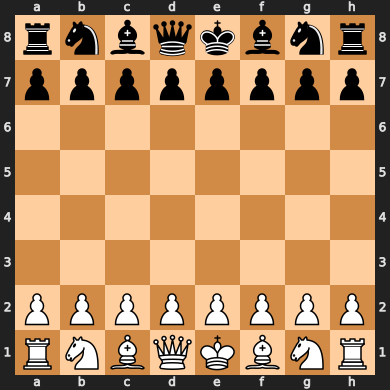

<LegalMoveGenerator at 0x7efc00227e90 (Nh3, Nf3, Nc3, Na3, h3, g3, f3, e3, d3, c3, b3, a3, h4, g4, f4, e4, d4, c4, b4, a4)>


KeyboardInterrupt: ignored

In [18]:
import time
from IPython.display import clear_output

def play_chess(model):
  board = chess.Board()
  while True:
    # Player move
    #show_board(board)
    clear_output(wait=True)
    display(board)
    time.sleep(0.25)

    print(board.legal_moves)
    move = input("Player Move: ")
    board.push_san(move)

    clear_output(wait=True)
    display(board)
    time.sleep(0.5)

    if board.is_game_over():
      clear_output(wait=True)
      display(board)
      time.sleep(0.5)
      print("You win!")
      board
      break

    # AI Move
    
    ai_move, _ = get_ai_move(model,board)
    board.push(ai_move)

    if board.is_game_over():
      clear_output(wait=True)
      display(board)
      time.sleep(0.5)
      print("You Lose!")
      board
      break
  return

play_chess(model)
